In [1]:
import basestations as bs
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

# ----------------------------------------------------------------
# 1. Basic functions (Poisson point generation, max SNR calculation, approximated model, etc.)
# ----------------------------------------------------------------

def generate_hppp(lambda_intensity, space_range):
    """Generate points from a 2D homogeneous Poisson point process (HPPP)."""
    area = space_range**2
    num_points = np.random.poisson(lambda_intensity * area)

    x_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    y_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    return np.column_stack((x_coords, y_coords))

def calculate_max_eavesdropper_snr(eavesdropper_density, space_range, alpha):
    """ Evaluate the maximum SNR of randomly placed eavesdroppers in a single experiment (sample). """
    points = generate_hppp(eavesdropper_density, space_range)
    if len(points) == 0:
        return 0.0
    distances = np.linalg.norm(points, axis=1)
    # 도청자 채널 g ~ Exponential(1), 경로손실 d^-α
    snrs = np.random.exponential(scale=1.0, size=len(distances)) / distances**alpha
    return np.max(snrs)

def approximated_SPSC_prob(kappa, distance, a=1.0, p=1.0):
    """
        SPSC ≈ exp(- a * (kappa^p) * distance^3).
    """
    return np.exp(- a * (kappa**p) * distance**2)

def fit_power_kappa(kappa_array, spsc_array, distance):
    """
    Estimate (a, p) by curve_fit:
      min_{a,p} Σ [ spsc_i - exp(- a*(kappa_i^p)*distance^2 ) ]^2
    """
    popt, _ = curve_fit(
        lambda xdata, a, p: approximated_SPSC_prob(xdata, distance, a, p),
        kappa_array, 
        spsc_array,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )
    return popt[0], popt[1]

def single_experiment(eavesdropper_density, space_range, alpha, legit_distance):
    """
    Single experiment for parallel processing.
    """
    max_eve_snr = calculate_max_eavesdropper_snr(eavesdropper_density, space_range, alpha)
    legit_snr = np.random.exponential(scale=1.0) / (legit_distance**alpha)
    return int(legit_snr > max_eve_snr)

# ----------------------------------------------------------------
# 2. Parallel Monte-Carlo simulation for SPSC vs. density
# ----------------------------------------------------------------

def simulate_spsc_vs_density_parallel(density_list, space_range, alpha, legit_distance, num_experiment=10000, n_jobs=-1, verbose=True):
    """
    Compute SPSC probability for multiple eavesdropper densities in parallel.

    Returns:
      kappa_array, spsc_array
    """
    kappa_list = []
    spsc_list = []

    for idx, eavesdropper_density in enumerate(density_list):
        kappa = (np.pi * eavesdropper_density
                 / np.sin(np.pi * 2 / alpha))
        kappa_list.append(kappa)

        # Repeat the experiment for num_experiment times
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_experiment)(eavesdropper_density, space_range, alpha, legit_distance)
            for _ in range(num_experiment)
        )
        spsc_est = np.mean(results)
        spsc_list.append(spsc_est)

        if verbose:
            print(f"{idx} | density={eavesdropper_density:.2e}, SPSC={spsc_est:.4f}")

    return np.array(kappa_list), np.array(spsc_list)


In [2]:
# (A) Environment setup
alpha = 3.0  # paathloss exponent
space_range = 10000
num_experiment = 50000
density_list = np.logspace(-9, -3, 30)  # log-scale eavesdropper density
distance_array = np.array([50, 100, 200, 300])  # legitimate distance

all_results = {}

# (B) Simulation for each distance
for legit_distance in distance_array:
    print(f"Starting simulation for distance={legit_distance:.1f}...")
    kappa_array, spsc_array = simulate_spsc_vs_density_parallel(
        density_list, space_range, alpha, legit_distance,
        num_experiment=num_experiment, n_jobs=-1, verbose=False
    )

    # fitting the approximated model
    a_opt, p_opt = fit_power_kappa(kappa_array, spsc_array, legit_distance)
    approx_spsc_array = approximated_SPSC_prob(kappa_array, legit_distance, a_opt, p_opt)
    print(f"fitted parameters for distance={legit_distance:.1f}: a={a_opt:.4f}, p={p_opt:.4f}\n")
    
    # Save the results
    all_results[legit_distance] = {
        "kappa_array": kappa_array,
        "spsc_array": spsc_array,
        "approx_spsc_array": approx_spsc_array,
        "a_opt": a_opt,
        "p_opt": p_opt,
    }

Starting simulation for distance=50.0...
fitted parameters for distance=50.0: a=0.2226, p=0.8049

Starting simulation for distance=100.0...
fitted parameters for distance=100.0: a=0.1635, p=0.8011

Starting simulation for distance=200.0...
fitted parameters for distance=200.0: a=0.1289, p=0.8044

Starting simulation for distance=300.0...
fitted parameters for distance=300.0: a=0.1163, p=0.8092



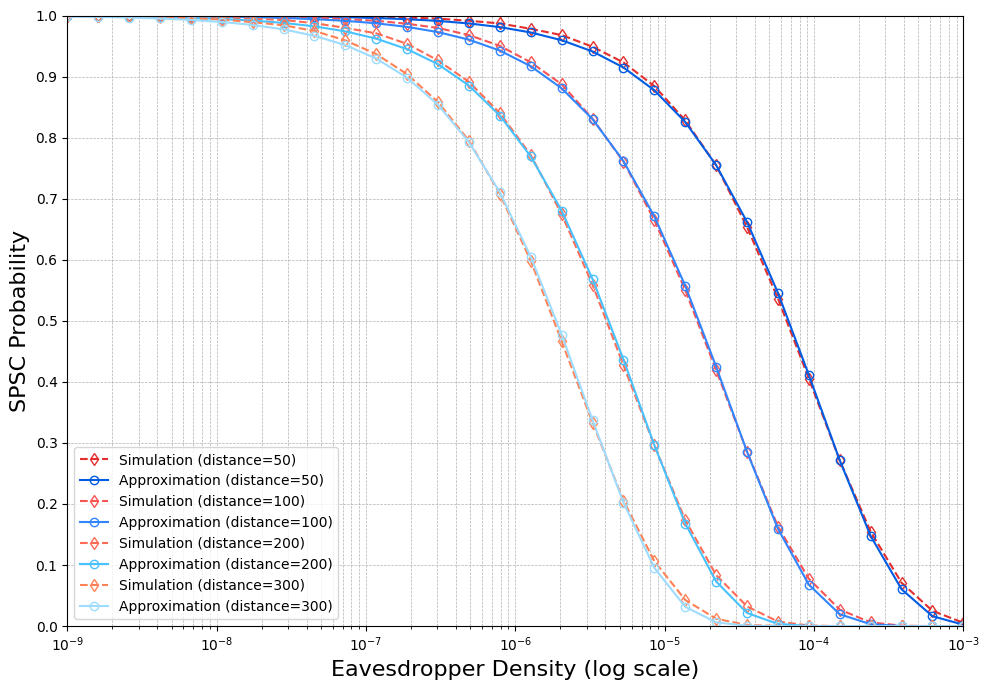

In [3]:
colors_red = np.array([
[228, 46, 46],
[249, 84, 84],
[255, 108, 86],
[255, 130, 86],
]) / 255.
colors_blue = np.array([
[0, 92, 226],
[49, 133, 255],
[72, 194, 255],
[158, 220, 255],
]) / 255.

fontsize = 16
font = 'arial'

# (C) Plot the results
plt.figure(figsize=(10, 7))
for i, (legit_distance, results) in enumerate(all_results.items()):
    plt.plot(density_list,
             results["spsc_array"],
             label=f"Simulation (distance={legit_distance:.0f})",
             marker='d',
             markerfacecolor='none',
             color=colors_red[i],
             linestyle='--', 
             )
    plt.plot(density_list, 
             results["approx_spsc_array"],
             label=f"Approximation (distance={legit_distance:.0f})",
             marker='o', 
             markerfacecolor='none',
             color=colors_blue[i],)

plt.xscale('log')
plt.xlabel('Eavesdropper Density (log scale)', fontsize=fontsize)
plt.ylabel('SPSC Probability', fontsize=fontsize)
plt.ylim(0, 1)
plt.xlim(density_list[0], density_list[-1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

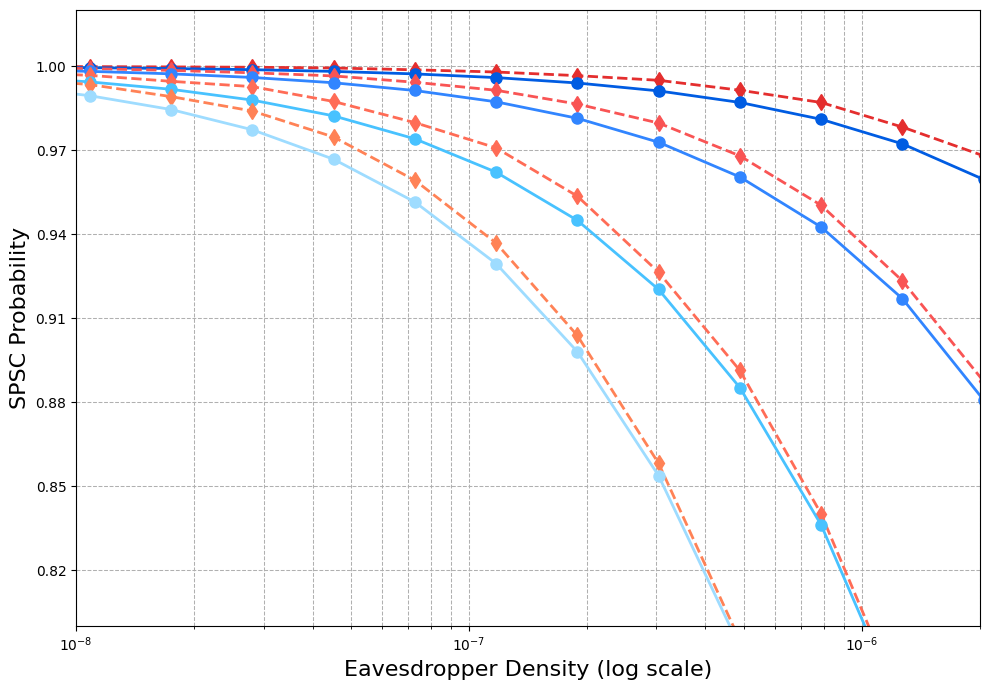

In [4]:
# (C-1, Optional) Plot the magnified results with limited density range.
plt.figure(figsize=(10, 7))
for i, (legit_distance, results) in enumerate(all_results.items()):
    plt.plot(density_list,
             results["spsc_array"],
             label=f"Simulation (distance={legit_distance:.0f})",
             marker='d',
             markersize=8,
             color=colors_red[i],
             linestyle='--', 
             linewidth=2.0,
             )
    plt.plot(density_list, 
             results["approx_spsc_array"],
             label=f"Approximation (distance={legit_distance:.0f})",
             marker='o', 
             markersize=8,
             color=colors_blue[i],
             linewidth=2.0,
             )

# from matplotlib.ticker import MultipleLocator
plt.xscale('log')
plt.xlabel('Eavesdropper Density (log scale)', fontsize=fontsize)
plt.ylabel('SPSC Probability', fontsize=fontsize)
plt.ylim(0.80, 1.02)
plt.xlim(1e-8, 2e-6)
plt.yticks(np.arange(0.82, 1.01, 0.03))
# ax = plt.gca()  # 현재 Axes 객체 가져오기
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
# plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.25)   # 보조 틱
plt.grid(True, which='both', linestyle='--', linewidth=.75)
plt.tight_layout()
plt.show()